In [1]:
from __future__ import print_function, division
#Importa el modulo future, que permite la compatibilidad de versiones de Python
import sunpy.timeseries
#Importa la clase TimeSeries de la libreria Sunpy
from sunpy.net import Fido, attrs as a
#Importa la clase Fido de la libreria Sunpy
from sunpy.net import jsoc
from sunpy.time import TimeRange
#Importa la clase TimeRange de la libreria Sunpy
import sunpy.data.sample
#Importa los datos de muestra de la libreria Sunpy
import sunpy.map
#Importa la funcion Map de la libreria Sunpy
from sunpy.util.metadata import MetaDict
#Importa la clase MetaDict de la libreria Sunpy
from sunpy.time import parse_time
#Importa la funcion parse_time de la libreria Sunpy
from sunpy.visualization.animator import LineAnimator
#Importa el modulo de visualizacion animada se Sunpy
import matplotlib.pyplot as plt
%matplotlib inline
#Importa la libreria Matplolib de Python
from matplotlib import animation as an
#Importa de matplotlib el modulo animation
import numpy as np
#Importa la libreria Numpy de Python
import pandas as pd
#Importa la libreria Pandas de Python
import datetime 
#Importa el modulo DateTime de Python
import math
#Importa el modulo Math de Python
import astropy.units as u
#Importa el paquete de unidades de la libreria Astropy
from astropy.time import Time
#Importa el modulo de timepo de la libreria Astropy
from astropy.table import Table
#Importa el modulo de tablas de la libreria Astropy
from astropy.io import fits
#Importa el paquete de archivos FITS de la libreria Astropy
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
#Las lineas anteriores importan el modulo de ejes 3D de la libreria Matplotlib
from skimage.feature import peak_local_max
#Importa la función peak_local_max de la libreria scikit-image
import cv2 as cv
#Importa la libreria de OpenCV
from glob import glob
#Importa el modulo glob de Python
from scipy import ndimage
#Importa el modulo ndimage de Scipy
import scipy.integrate as si
#Importa el modulo de intregacion de cuadraturas de scipy
from astropy.coordinates import SkyCoord
#Importa el mddulo Skycoord de astropy
from IPython.display import HTML
#Paquete para presentar los videos en el notebook
from sklearn.linear_model import LinearRegression
#Importa el modulo LinearRegression de sklearn
import matplotlib.image as mpimg
#Abre el paquete image para lectura de imagenes
import os

In [2]:
#Lista de Parámetros iniciales y sensitivos
umbral, max_umbral = 0.5, 0.8  #Umbral: usado para seleccionar los poi, max: usado para encerrar los por 
radioROI = 0.9 #Radio del ROI
colors = ['cyan','red','green','navy','black','blue','lime','tomato','magenta']

In [3]:
#Selecciona la fecha para utilizarla en el nombre de los archivos. Se guarda como tipo string
#Obtiene la fecha de cualquier formato de fechas especificados
#Acomoda la fecha en el formato dia-mes-año
def obtainDate(TimeDate):
    date = []
    time = []
    newdate = ""
    newtime = ""
    x=2
    if ' ' in TimeDate:  #Si el dato esta separada por espacio
        a = TimeDate.split()
        b = a[0].split(sep='-')
        c = a[1].split(sep = ':')
        while x != -1:
            date.append(b[x])
            x = x-1
        for element in date:
            if len(element) == 4:
                newdate = newdate + element
            else:
                newdate = newdate + element + "-"
        for i in range(0,len(c)):
            time.append(c[i])    
        newtime = "_".join(time)
        
    if 'T' in TimeDate: #Si la dato esta separada por T
        a = TimeDate.split('T')
        b = a[0].split(sep='-')
        c = a[1].split(sep = ':')
        if '-' in a[0]:    #Si esta separado del tiempo por T
            b = a[0].split(sep='-')
            while x != -1:
                date.append(b[x])
                x = x-1
            for element in date:
                if len(element) == 4:
                    newdate = newdate + element
                else:
                    newdate = newdate + element + "-"
        if '/' in a[0]:    #Si esta separado del tiempo por /
            b = a[0].split(sep='/')
            while x != -1:
                date.append(b[x])
                x = x-1
            for element in date:
                if len(element) == 4:
                    newdate = newdate + element
                else:
                    newdate = newdate + element + "-"
        for i in range(0,len(c)):
            time.append(c[i])
        newtime = "_".join(time)
        
    if '_' in TimeDate: #Si el dato esta separado por _
        a = TimeDate.split('_')
        b = a[0].split(sep='-')
        c = a[1].split(sep = ':')
        while x != -1:
            date.append(b[x])
            x = x-1
        for element in date:
            if len(element) == 4:
                newdate = newdate + element
            else:
                newdate = newdate + element + "-"
        for i in range(0,len(c)):
            time.append(c[i])
        newtime = "_".join(time)
        
    return newdate, newtime

In [4]:
def fechaUsuario():
    #Funcion que selecciona el tipo de fecha que el usuario desea analizar
    print("El presente script busca y descarga los TimeSeries de las curvas XRS,\na partir de un rango de tiempo que ingresa el usuario.")
    print("Seguidamente se detectan los picos en las curvas y se extraen las fechas de dichos picos.")
    print("Se define un delta de tiempo y se descargan las imágenes FITS. Finalmente se estudian las\nintensidades de las imágenes FITS en una región de interés (ROI).")
    print('Acontinuación ingrese 1 si desea que se realice un anáisis por horas, ingrese 2 si desea un análisis diario,'
               'o ingrese 3 si desea un análsis por meses.')
    n = input('Valor:')
    if int(n) == 1:
        #Se le solicita el ingreso de datos al usuario de la fecha y hora desde la cual quiere visualizar los datos
        initialTime = input("Ingrese la fecha y hora inicial: ")
        finalTime = input("Ingrese la fecha y hora inicial: ")
        time_range = TimeRange(initialTime, finalTime)
        print("\nEl intervalo de tiempo ingresado es:\n", time_range)

    if int(n)==2: 
        #Se le solicita el ingreso de datos al usuario
        initialTime = input("Ingrese la fecha inicial: ")
        initialTime = initialTime + ' 00:00:00'
        finalTime = input("Ingrese la fecha final: ")
        finalTime = finalTime + ' 23:59:59'
        time_range = TimeRange(initialTime, finalTime)
        print("\nEl intervalo de tiempo ingresado es:\n", time_range)

    if int(n)==3:
        #Se le solicita el ingreso de datos al usuario
        initialTime = input("Ingrese la fecha inicial: ")
        initialTime = initialTime + ' 00:00:00'
        finalTime = input("Ingrese la fecha final: ")
        finalTime = finalTime + ' 23:59:59'
        time_range = TimeRange(initialTime, finalTime)
        print("\nEl intervalo de tiempo ingresado es:\n", time_range)
        
    return initialTime, finalTime, time_range

In [5]:
initialTime, finalTime, time_range = fechaUsuario()

El presente script busca y descarga los TimeSeries de las curvas XRS,
a partir de un rango de tiempo que ingresa el usuario.
Seguidamente se detectan los picos en las curvas y se extraen las fechas de dichos picos.
Se define un delta de tiempo y se descargan las imágenes FITS. Finalmente se estudian las
intensidades de las imágenes FITS en una región de interés (ROI).
Acontinuación ingrese 1 si desea que se realice un anáisis por horas, ingrese 2 si desea un análisis diario,o ingrese 3 si desea un análsis por meses.
Valor:1
Ingrese la fecha y hora inicial: 2011-06-07 00:00:00
Ingrese la fecha y hora inicial: 2011-06-07 06:00:00

El intervalo de tiempo ingresado es:
    Start: 2011-06-07 00:00:00
    End:   2011-06-07 06:00:00
    Center:2011-06-07 03:00:00
    Duration:0.25 days or
           6.0 hours or
           360.0 minutes or
           21600.0 seconds



In [6]:
newdate, newtime = obtainDate(initialTime)

In [7]:
def instrument():
    c = newdate.split('-')
    if int(c[2]) < 2010:
        inst = 'EIT'
    elif int(c[2]) == 2010 and int(c[1])<6:
        inst = 'EIT'
    else:
        inst = 'XRS'
    return inst

In [8]:
inst = instrument()

In [9]:
#Crea las rutas de los directorios a partir de lol nombre de los instrumentos
def directoryRoute(instrument):
    Dir = 'DatosJupyterSun/'+ instrument + '_data/' + instrument +'_FITS/'
    Dir3D = 'DatosJupyterSun/' + instrument + '_data/3D/'
    DirVideo = 'DatosJupyterSun/'+ instrument + '_data/AnimationVideo/'
    return Dir, Dir3D, DirVideo

In [10]:
fitsDir, fitsDir3D, fitsDirVideo = directoryRoute(inst)

In [11]:
#Se buscan los datos con el metodo Fido.search(), se le pasa el intervalo de tiempo ingresado
def searchData(timeRange):
    resultSearchXRS = Fido.search(a.Time(timeRange.start, timeRange.end), a.Instrument(inst))
    #Muestra el resultado de la busqueda
    print(resultSearchXRS)
    return resultSearchXRS

In [12]:
resultXRS = searchData(time_range)

Results from 1 Provider:

1 Results from the XRSClient:
     Start Time           End Time      Source Instrument Wavelength
       str19               str19         str4     str4       str3   
------------------- ------------------- ------ ---------- ----------
2011-06-07 00:00:00 2011-06-07 23:59:59   nasa       goes        nan




In [13]:
#Se descargan los datos de la curva con el metodo Fido.fetch()
def downloadData(results):
    filesXRS = Fido.fetch(results, path='DatosJupyterSun/CurvasXRS/')
    return filesXRS

In [14]:
files = downloadData(resultXRS)

In [15]:
#Grafica los datos de las fechas.
def dataGraphics(data):
    #Se crea un objeto TimeSeries con los datos descargados
    goesXRS_TS = sunpy.timeseries.TimeSeries(data, source= inst, concatenate=True)
    #Se plotea la curva
    goesXRS_TS.peek()
    return goesXRS_TS

/home/armitage/miniconda3/envs/Solar/lib/python3.8/functools.py:875: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/armitage/miniconda3/envs/Solar/lib/python3.8/asyncio/base_events.py:654: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  _warn(f"unclosed event loop {self!r}", ResourceWarning, source=self)


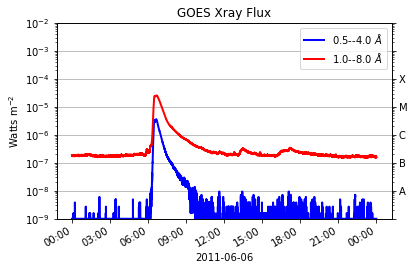

In [16]:
goes_ts = dataGraphics(files)

In [17]:
#Se declara la funcion findpeaks, recibe como parametros los datos de la curva y una constante
def findpeaks(series, DELTA):
    # Se declaran los valores iniciales; dos infinitos, dos listas vacias y dos booleanos
    mn, mx = np.Inf, -np.Inf
    minpeaks = []
    maxpeaks = []
    lookformax = True
    start = True
    #Se itera sobre cada uno de los elementos en la serie
    #Se usa un ciclo for para tomar el valor de la serie que se itera
    for time_pos, value in series.iteritems():
    #Se usa un if que compara si el valor de la iteracion es mas grande que el declarado al inicio, si 
    #lo es, se sobreescribe el valor y se guarda la posición del maximo en mxpos 
        if value > mx:
            mx = value
            mxpos = time_pos
    #Este if funciona igual que el anterior, solo que compara los valores minimos en lugar de los maximos
        if value < mn:
            mn = value
            mnpos = time_pos
    #En este if se entra si la variable lookformax vale True
        if lookformax:
    #Se usa un if para comparar si el valor de la serie durante la iteracion es menor al valor maximo,
    #declarado al inicio, mas la constante recibida por la funcion. Si esto se cumple, se guardan los
    #valores de mx y mxpos obtenidos en los if's anteriores en la lista vacia declarada al principio
    #y cambia a False lookformax
            if value < mx-DELTA:
                # un maximo local
                maxpeaks.append((mxpos, mx))
                mn = value
                mnpos = time_pos
                lookformax = False
    #El elif se encarga de guardar los valores de mnpos y mn en la lista vacia.
            elif start:
                # un minimo local al principio
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                start = False
    #El if y el elif anteriores estan identados dentro del if de lookformax; el siguiente else es el 
    #que le corresponde
        else:
    #Se usa un if para compara si el valor de la serie de la iteracion es mayor que el valor minimo,
    #declarado al principio, mas la constante recibida por la funcion. Se guardan los valores minimos
    #en la lista vacia
            if value > mn+DELTA:
                # minimo local
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                lookformax = True
    
    # Se vuelve a revisar los valores minimos y maximos
    if value > mn+DELTA:
        maxpeaks.append((mxpos, mx))
    elif value < mx-DELTA:
        minpeaks.append((mnpos, mn))
    return minpeaks, maxpeaks

In [18]:
#Imprime los datos de los picos presentes y la curva
def extractXRS(data):
    #Se extrae la serie xrsb, la serie roja
    xrs_Series = data.data['xrsb']

    #Se extraen los picos mínimos y máximos de la serie utilizando la funcion findpeaks
    min_picos, max_picos = findpeaks(xrs_Series, DELTA=0.0000001)

    #Se imprimen los picos máximos encontrados 
    print ('Los picos máximos son:')
    print (pd.DataFrame(max_picos))


    #Se plotea la curva con los picos máximos utilizando los metodos de la libreria Matplotlib
    plt.figure() #Crea la figura
    plt.ylabel('Sunspot Number') #Etiqueta el eje y
    plt.xlabel('Time') #Etiqueta el eje x
    plt.title('Peaks in TimeSeries') #Pone el titulo de la imagen
    xrs_Series.plot() #Plotea la curva
    plt.scatter(*zip(*max_picos), color='red', label='max') #Punto de color rojo en máximos
    plt.legend() #Activa la leyenda en la imagen
    plt.grid(True) #Activa la cuadricula en la imagen 
    plt.show() #Muestra la figura
    
    return xrs_Series, min_picos, max_picos

Los picos máximos son:
                              0             1
0 2011-06-07 06:30:57.441999912  2.456800e-05
1 2011-06-07 06:32:52.128999949  2.448400e-05
2 2011-06-07 06:33:51.518999934  2.450500e-05
3 2011-06-07 06:39:11.001999855  2.546000e-05
4 2011-06-07 06:41:24.118999958  2.555400e-05
5 2011-06-07 13:28:05.584999919  3.224900e-07
6 2011-06-07 17:12:10.468999863  3.434800e-07


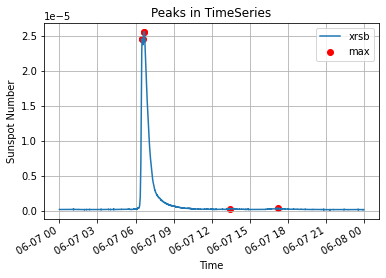

In [19]:
xrs_Series, min_picos, max_picos = extractXRS(goes_ts)

In [20]:
#Realiza una selección de los picos más altos y contierte los demas en 0.
#Vuelve a imprimir la gráfica
def selectPicos(xrs, maxPicos):
    #Se declara una lista vacia donde se guardarán los picos mayores a 1x10^(-6)
    maxPicosArriba10e_m06 = []

    #Se recorre y se revisa la lsita donde se habian guardado los valores maximos
    for i in range(0, len(maxPicos)-1):
        if maxPicos[i][1] > 1.0e-06:
            maxPicosArriba10e_m06.append(maxPicos[i])
    
    #Se imprimen picos por encima del limite establecido
    print ('Los picos máximos por encima de 1x10^(-6) son: \n')
    print (pd.DataFrame(maxPicosArriba10e_m06))

    #Se plotea la curva con los picos máximos, volviendo a usar la libreria Matplotlib
    plt.figure() #Crea la figura
    plt.ylabel('Sunspot Number') #Etiqueta el eje y
    plt.xlabel('Time') #Etiqueta el eje x
    plt.title('Peaks in TimeSeries') #Pone el titulo de la imagen
    xrs.plot() #Plotea la curva
    plt.scatter(*zip(*maxPicosArriba10e_m06), color='red', label='max') #Punto de color rojo en máximos
    plt.legend() #Activa la leyenda en la imagen
    plt.grid(True) #Activa la cuadricula en la imagen 
    plt.show() #Muestra la figura
    
    return maxPicosArriba10e_m06 #Es un rango de tiempo dentro del cual se encuentran los picos

Los picos máximos por encima de 1x10^(-6) son: 

                              0         1
0 2011-06-07 06:30:57.441999912  0.000025
1 2011-06-07 06:32:52.128999949  0.000024
2 2011-06-07 06:33:51.518999934  0.000025
3 2011-06-07 06:39:11.001999855  0.000025
4 2011-06-07 06:41:24.118999958  0.000026


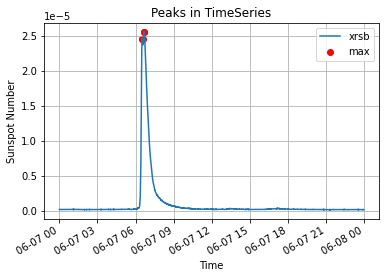

In [21]:
maxPicos10e06 = selectPicos(xrs_Series, max_picos)

In [22]:
#Guarda en un archivo csv los datos de los picos máximos
def saveMaxPicos(maxPicos10_06):
    #Se define DataFrame de pandas para guardar información en archivo .csv
    dataFrameMaxPicos = pd.DataFrame(maxPicos10_06)
    dataFrameMaxPicos.to_csv('DatosJupyterSun/maxPicos.csv', sep='\t', index=False)
    return dataFrameMaxPicos

In [23]:
dataFrameMaxPicos = saveMaxPicos(maxPicos10e06)

In [24]:
#Funcion que extrae el pico de interés y encuentra su posicion.
def interesting_peak(data):
    data = pd.DataFrame(data) #se convierte en data frame los datos
    #Se inicializan las listas y variables
    pico = [] #Guarda los datos del Pico de Interes
    picodelta = []
    deltaT = 1800 #segundos antes y despues del pico de interes
    ti = [0]
    tf = [0]
    tmax = [0]
    cont1 = 0
    cont2 = 0
            
    #Se guardan los datos en la lista pico   
    for i in range(len(data)):
        if data.iat[i,0] > 1.0e-06:
            pico.append(data.iloc[i])
            cont1 += 1
            if cont1 == 1:
                cont2 = i
                
    #se guardan los datos en la lista picodelta            
    pico = pd.DataFrame(pico)
    for i in range(len(data)): 
        if i <= cont2 + deltaT + len(pico):
            if i >= cont2 - deltaT:
                picodelta.append(data.iloc[i])
                  
    #Se transforman las listas en Data Frames y pico maximo        
    picodelta = pd.DataFrame(picodelta)
    tmaxX = pico.idxmax()   
    
    # Se compara el valor de los de los elementos de peak para hallar el más alto
    ti[0] = pico.iloc[0]
    ti = pd.DataFrame(ti)
    tf[0] = pico.iloc[-1]
    tf = pd.DataFrame(tf)
    tmax[0] = pico.max()
    tmaxY = pd.DataFrame(tmax)
    
    return pico, picodelta, ti, tf, tmaxY, tmaxX #dateTime, xpicoMax, ypicoMax

In [25]:
#Funcion que muestra la grafica con ti, tmax y tf
def fullCurve(data):
    solopico, pico, ti, tf, tmaxY, tmaxX = interesting_peak(data)

    plt.figure() 
    plt.ylabel('Sunspot Number') #Etiqueta el eje y
    plt.xlabel('Time') #Etiqueta el eje x
    plt.tick_params(axis='x', rotation = 45)
    plt.title('Peaks in TimeSeries (delta t = 30min)') #Pone el titulo de la imagen
    plt.plot(pico) #Plotea la curva
    plt.scatter(ti.index[0],ti.iat[0,0], color='navy', label='ti') #Punto de color rojo en ti
    plt.axvline(x = ti.index[0], linestyle = '--', color = 'navy', label = 'ti Line') 
    plt.scatter(tmaxX,tmaxY.iat[0,0], color='red', label='tmax') #Punto de color rojo en máximo
    plt.axvline(x = tmaxX, linestyle = '--', color = 'red', label = 'tmax line') 
    plt.scatter(tf.index[0],tf.iat[0,0], color='orange', label='tf') #Punto de color rojo en tf
    plt.axvline(x = tf.index[0], linestyle = '--', color = 'orange', label = 'tf Line') 
    plt.legend() #Activa la leyenda en la imagen
    plt.grid(True) #Activa la cuadricula en la imagen 
    plt.show() #Muestra la figura

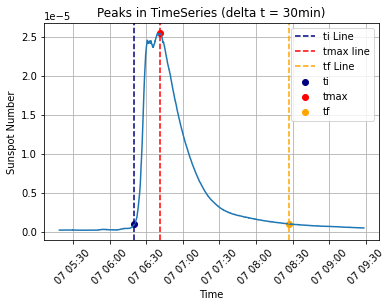

In [26]:
fullCurve(xrs_Series)

In [27]:
# Funcion que se encarga de hallar el area bajo la curva Afluencia
#Se utiliza la regla de Simpson para hallar el area de la curva
def areaCurve(data):
    solopico, pico, ti, tf, tmaxY, tmaxX = interesting_peak(data)
    x = []
    y = []
    cont= 0
    tmax = pd.DataFrame(tmaxX)
    area = 0

    def simpsonRule(a,b,y0,y1,y2):
        h = (b-a)/2
        f = (h/3)*(y0 + 4*y1 + y2)
        return f

    for i in range(len(solopico)):
        if solopico.index[i] < tmax.iat[0,0]:
            y.append(solopico.iat[i,0])
            x.append(cont)
            cont += 2
    
    #Cacula el area de la region [ti, tmax]
    for l in range(len(y)-2):
        area = area + simpsonRule(x[l],x[l+2],y[l],y[l+1],y[l+2])
        l = l+1
    
    print('El area en el rango [ti, tmax] es: ', area) 
    return area


In [28]:
areaCurva = areaCurve(xrs_Series)

El area en el rango [ti, tmax] es:  0.0429074164423279


In [29]:
#Obtiene la velocidad Vcme
def Vcme(F):
    logV = 0.24*np.log(F) + 3.36
    V = np.exp(logV)
    print("Vcme =", V, "m/s")

In [30]:
Vcme(areaCurva)

Vcme = 13.52188465242891 m/s


In [31]:
#Define un TimeRange de una hora, a partir de la hora central extraídaen la curva XRS. 
#Con el TimeRange se busca en la base de datos JSOC los archivos FITS
def returnDataRange(centralDate, delta_min):
    #Se declara el inicio del rango de tiempo con TimeRange().previous() y el final con TimeRange
    date_rangeUp = TimeRange(centralDate, delta_min * u.min).previous()
    date_rangeFinal = TimeRange(date_rangeUp.start, date_rangeUp.next().end)
    
    return date_rangeFinal

In [32]:
#Se define el TimeRange, a partir de un pico máximo
maxPicoTR = returnDataRange(maxPicos10e06[4][0], 30) #Se llama al funcion returnDataRange
print(maxPicoTR) #Se imprime el intervalo de tiempo

    Start: 2011-06-07 06:11:24
    End:   2011-06-07 07:11:24
    Center:2011-06-07 06:41:24
    Duration:0.04166666666666674 days or
           1.0000000000000018 hours or
           60.00000000000011 minutes or
           3600.0000000000064 seconds



/home/armitage/miniconda3/envs/Solar/lib/python3.8/functools.py:875: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


In [33]:
#Se buscan los datos que corresponden a la serie aia.lev1, se usa una cadencia de 12 segundos y 
#una longitud de onda de 193 Ångström. Estos datos se buscan utilizando el rango de tiempo
#encontrado anteriormente. Una vez completada la busqueda, se despliega el resultado
def maxPicoSearch(data):
    results = Fido.search(a.Time(data.start, data.end), a.jsoc.Series('aia.lev1_euv_12s'), 
                         a.jsoc.Wavelength(193*u.AA), a.vso.Sample(2*u.minute),  
                         a.jsoc.Notify('yasser.wagon@ucr.ac.cr'))
    return results

In [34]:
resultsAIA = maxPicoSearch(maxPicoTR)
resultsAIA

T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str20,str7,str5,int64,int64
2011-06-07T06:11:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:13:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:15:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:17:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:19:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:21:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:23:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:25:26Z,SDO/AIA,AIA_2,193,2111
2011-06-07T06:27:26Z,SDO/AIA,AIA_2,193,2111


In [35]:
#Se procede a descargar los archivos FITS resultantes de la busqueda
def downloadMaxFiles(data):
    files = Fido.fetch(data, path=fitsDir + '{file}')

In [37]:
downloaded_files = downloadMaxFiles(resultsAIA)

/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/parfive/downloader.py:100: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  self.http_queue = asyncio.Queue(loop=self.loop)
/home/armitage/miniconda3/envs/Solar/lib/python3.8/asyncio/queues.py:48: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  self._finished = locks.Event(loop=loop)
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/parfive/downloader.py:101: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  self.http_tokens = asyncio.Queue(maxsize=self.max_conn, loop=self.loop)
/home/armitage/miniconda3/envs/Solar/lib/python3.8/asyncio/queues.py:48: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  self._finished = locks.Event(loop=loop)
/home/armitage

Export request pending. [id="JSOC_20200613_3249", status=2]
Waiting for 0 seconds...
62 URLs found for download. Full request totalling 363MB


/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/parfive/downloader.py:277: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  return self.tqdm(total=total, unit='file',


/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self

/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self

/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self

/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self

/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(
/home/armitage/miniconda3/envs/Solar/lib/python3.8/site-packages/aiohttp/connector.py:964: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  hosts = await asyncio.shield(self._resolve_host(


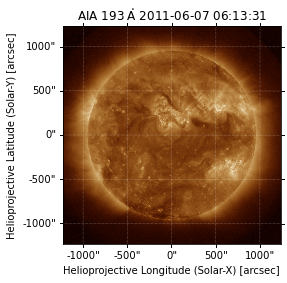

In [38]:
filename = fitsDir + 'aia.lev1_euv_12s.2011-06-07T061333Z.193.image_lev1.fits'
aiamap = sunpy.map.Map(filename)
plt.figure()
ax = plt.subplot(projection=aiamap)
aiamap.plot()
plt.show()

In [39]:
#Se abre archivo central FITS y se convierte a un objeto map de sunpy
def CentralMapDownloadedFile(directory):
    cont = 0
    for name in os.listdir(directory): #Cuenta el numero de archivos de imagen en el directorio
        if 'image_lev1.fits' in name:   #Se debe revisar que los archivos tengan esta parte en su nombre
            cont += 1
    numfiles = cont
    cont = 0
    for name in os.listdir(directory):
        if cont >= int(numfiles):
            if 'image_lev1.fits' in name:
                image_filename = str(directory)+ '/' + str(name)
        cont +=1
    
    #image_filename = str(directory)+ '/aia.lev1_euv_12s.2011-06-07T062533Z.193.image_lev1.fits'

    aiamap = sunpy.map.Map(image_filename) 
    aiamap1 = sunpy.map.Map(image_filename)
    #Las lineas anteriores crean los objetos map de la libreria Sunpy

    plt.figure() #Crea la figura
    ax = plt.subplot(projection=aiamap)
    aiamap.plot() #Plotea los datos
    plt.colorbar() #Plotea la barra de intensidad
    
    return aiamap, aiamap1, image_filename

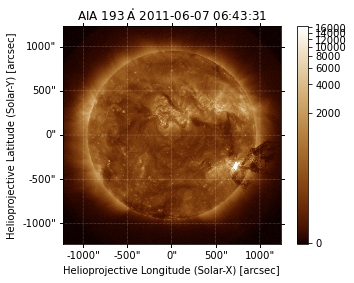

In [40]:
aiamap, aiamap1, fits_image_filename = CentralMapDownloadedFile(fitsDir)

In [41]:
#Hace el mapa 3D de intensidades de la imagen anterior
def Map3dImage(dataMap):
    x = np.arange(dataMap.data.shape[0])
    y = np.arange(dataMap.data.shape[1])
    X, Y = np.meshgrid(x, y)

    coordinates = peak_local_max(dataMap.data, min_distance=60, threshold_rel=0.3)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, aiamap.data)
    ax.view_init(elev=39, azim=55)
    peaks_pos = dataMap.data[coordinates[:, 0], coordinates[:, 1]]
    ax.scatter(coordinates[:, 1], coordinates[:, 0], peaks_pos, color='r')
    ax.set_xlabel('X Coordinates')
    ax.set_ylabel('Y Coordinates')
    ax.set_zlabel('Intensity')
    plt.show()

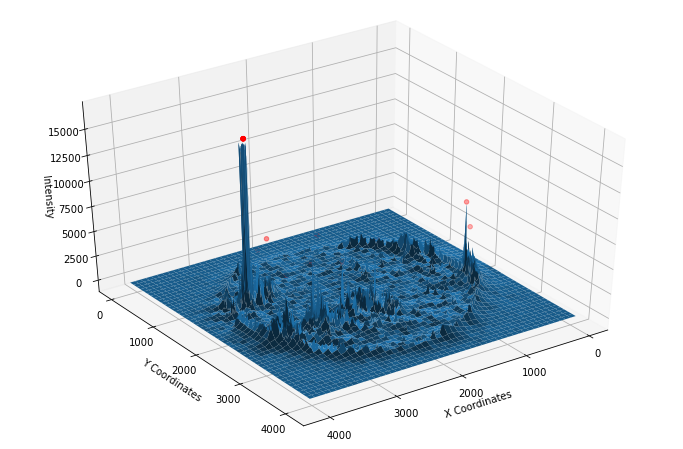

In [42]:
Map3dImage(aiamap)

In [43]:
#Extrae los datos importantes del .FITS
def sunDataExtract(dataMap):
    crpix1 = int(dataMap.meta['CRPIX1']) 
    crpix2 = int(dataMap.meta['CRPIX2'])
    #Las lineas anteriores extraen los datos de los pixeles del sol. La linea siguiente es el radio
    radioSolar = int(dataMap.meta['R_SUN'])
    CentroSol = np.array([crpix1, crpix2]) 

    #Se imprimen los datos
    print('El centro del disco solar está en el punto: ', CentroSol, 'pixel')
    print ('El radio del sol en pixeles es: ', radioSolar, 'pixeles')
    return radioSolar, CentroSol

In [44]:
rSun, sunCenter = sunDataExtract(aiamap)

El centro del disco solar está en el punto:  [2044 2048] pixel
El radio del sol en pixeles es:  1574 pixeles


In [45]:
#Función que dibuja el ROI en el mapa del plano solar
def drawROI(sunImageData, sunCenter, pixRadius):
    propRadius = int(radioROI * pixRadius)
    #cv.rectangle(sunImageData, (sunCenter[0] - propRadius, sunCenter[1] - propRadius), (sunCenter[0] + propRadius, sunCenter[1] + propRadius), 0, 30)
    cv.circle(sunImageData, (sunCenter[0], sunCenter[1]), propRadius, 0, 30, cv.LINE_AA)
    #Se crea el circulo en la imagen con el metodo circle de OpenCV y se retorna
    return sunImageData

In [46]:
#Funcion que reinicia la imagen solar
def clearROI(sunImageData):
    sunMap = sunpy.map.Map(sunImageData)
    return sunMap

In [47]:
def sunImageROI(image, CentroSol, radioSol):
    aiaMap = clearROI(image)
    drawROI(aiaMap.data, CentroSol, radioSol) #Se llama a la funcion para dibujar el ROI
    plt.figure() #Se crea la figura
    aiaMap.plot() #Plotea los datos
    plt.colorbar() #Plotea la barra de intensidad

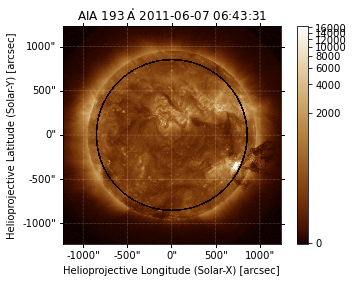

In [48]:
sunImageROI(fits_image_filename, sunCenter, rSun)

In [49]:
#Se ubican los picos de intensidad con la funcion peak_local_max de scikit-image
def findMaxPeak(dataImage, CentroSol, radioSol):
    coorPicos = peak_local_max(dataImage.data, min_distance=100, threshold_rel=umbral, indices=True)
    print('Los puntos de alta intensidad en el map son: \n') 
    print (pd.DataFrame(coorPicos)) #Se imprimen los picos de intensidad en forma de DataFrame de Pandas
    
    hpc_max = dataImage.pixel_to_world(coorPicos[:, 1]*u.pixel, coorPicos[:, 0]*u.pixel)
    fig = plt.figure() #Crea la figura
    ax = plt.subplot(projection=aiamap) 
    drawROI(dataImage.data, CentroSol, radioSol)
    dataImage.plot() #Plotea los datos
    ax.plot_coord(hpc_max, 'bx') #Plotea los puntos de intensidad
    plt.show() #Muestra la figura
    
    return coorPicos

Los puntos de alta intensidad en el map son: 

      0     1
0  1445  3213
1  1445  3214
2  1446  3213
3  1446  3214
4  2529  2893


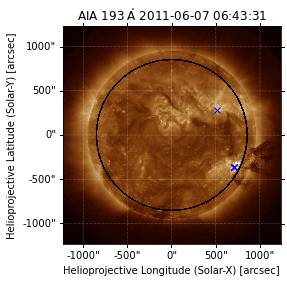

In [50]:
coorPicos = findMaxPeak(aiamap, sunCenter, rSun)

In [51]:
#Funcion que selecciona los POI dentro del ROI
def picosROI(coordenadasPicos, sunCenter, pixRadius):
    #prop es una medida del radio dentro del cual se encuentran los POI, esta no se dibuja.
    propRadius = int(radioROI * pixRadius)
    picosEnROI = []
    picosEnROICircular = []
    for l in range(0, len(coordenadasPicos)):
        r_peak = math.sqrt(((coordenadasPicos[l][0]-sunCenter[0])**2) + ((coordenadasPicos[l][1]-sunCenter[1])**2))
        if (r_peak < propRadius):
            picosEnROICircular.append(coordenadasPicos[l])
        
        
    for s in range(0, len(coordenadasPicos)-1):
        if (coordenadasPicos[s][0] > sunCenter[0] - propRadius and coordenadasPicos[s][0] < sunCenter[0] + propRadius):
            if(coordenadasPicos[s][1] > sunCenter[1] - propRadius and coordenadasPicos[s][1] < sunCenter[1] + propRadius):
                picosEnROI.append(coordenadasPicos[s])
                
    return np.array(picosEnROI), np.array(picosEnROICircular)

In [52]:
#Se ubican los picos de alta intensidad dentro del ROI 
picosen_roi, picosCircu = picosROI(coorPicos, sunCenter, rSun)

In [53]:
#Se imprimen solo los picos dentro del ROI y las coordenadas de cada pico
def picosROIimage(p_roi, p_circ):
    #Se limpia la imagen y se dibuja el ROI en ella
    aiamap = clearROI(fits_image_filename)
    drawROI(aiamap.data, sunCenter, rSun)
    #Se mapean las coordenadas en el map
    hpc_max1 = aiamap1.pixel_to_world(p_roi[:, 1]*u.pixel, p_roi[:, 0]*u.pixel)
    hpc_max2 = aiamap1.pixel_to_world(p_circ[:, 1]*u.pixel, p_circ[:, 0]*u.pixel)

    #Se grafica la imagen con los picos de alta intensidad dentro del ROI, marcados con una equis azul
    fig = plt.figure()
    ax = plt.subplot(projection=aiamap)
    aiamap.plot()
    for i in range(len(hpc_max2)):
        ax.plot_coord(hpc_max2[i], 'v' ,color = colors[i])    
    plt.show()
    
    for i in range(len(hpc_max2)):
        print('El máximo de color ' + str(colors[i]) + ' tiene coordenadas: (', str(hpc_max2.Tx[i]), ',', str(hpc_max2.Ty[i]),')')
    
    return hpc_max2

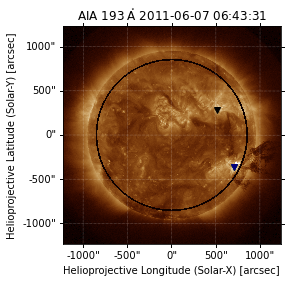

El máximo de color cyan tiene coordenadas: ( 703.054arcsec , -361.135arcsec )
El máximo de color red tiene coordenadas: ( 703.655arcsec , -361.134arcsec )
El máximo de color green tiene coordenadas: ( 703.054arcsec , -360.534arcsec )
El máximo de color navy tiene coordenadas: ( 703.654arcsec , -360.534arcsec )
El máximo de color black tiene coordenadas: ( 510.171arcsec , 289.893arcsec )


In [54]:
hpc_max2 = picosROIimage(picosen_roi, picosCircu)

In [55]:
#Celda que se encarga de dibujare el contorno al rededor de los POI
def contourMap(data, data1):
    mask = data.data < data.max()*max_umbral
    data1.mask = mask
    data2 = ndimage.gaussian_filter(data.data * ~mask, 14)
    data2[data2 < 15] = 0
    aiamap2 = sunpy.map.Map(data2, data.meta)
    labels, n = ndimage.label(aiamap2.data)
    size = ndimage.sum(mask, labels, range(n+1))
    return labels, n, size

In [56]:
#Presenta la imagen con el POI encerrado
def contourImage(fits_image_filename, sunCenter, rSun):
    aiamap = clearROI(fits_image_filename)
    drawROI(aiamap.data, sunCenter, rSun)
    labels, n, size = contourMap(aiamap, aiamap1)

    plt.figure()
    ax = plt.subplot(projection=aiamap)
    aiamap.plot()
    plt.contour(labels)
    plt.figtext(0.3, 0.15, f'Number of regions = {n}', color='white')
    plt.show()
    #plt.savefig('sunimage.png')

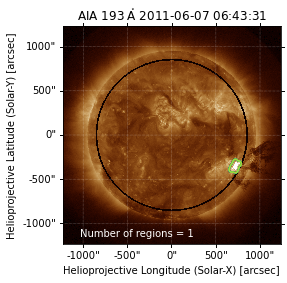

In [58]:
contourImage(fits_image_filename,sunCenter, rSun)

In [59]:
#Se guardan las imagenes 3D de intensidades de cada uno de los mapas dentro de la fecha escogida al principio.
#Las imagenes se guardan en archivos jpeg en el directorio 3D dentro de DatosJupyterSun
def guardar3DPlotROI(picosEnROI, center, pixRadius):
    #Se obtienen las direcciones de los archivos FITS a gráficar
    fitsPaths= sorted(glob(fitsDir +'*193.image_lev1.fits'))
    # Se itera sobre cada archivo FITS del directorio
    for i in range(0, len(fitsPaths)):
        # Se crea objeto Map y se obtiene el centro(sunC) y radio(radiusSun) 
        # del disco solar de los metadatos 
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        propRadius = int(radioROI * pixRadius)
        
        x = np.arange(aiamapFITS_i.data.shape[0])
        y = np.arange(aiamapFITS_i.data.shape[1])
        X, Y = np.meshgrid(x[int(center[0]-propRadius): int(center[0]+propRadius)], 
                            y[int(center[1]-propRadius): int(center[1]+propRadius)])
        
        time_obs = aiamapFITS_i.meta['date-obs']
        newdate, newtime = obtainDate(time_obs)
        print(newdate, newtime)
    
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, aiamapFITS_i.data[int(center[0]-propRadius): int(center[0]+propRadius), 
                                        int(center[1]-propRadius): int(center[1]+propRadius)])
        ax.set_zlim(0, 14000)
        ax.view_init(elev=39, azim=64)
        peaks_pos = aiamapFITS_i.data[picosEnROI[:, 0], picosEnROI[:, 1]]
        ax.scatter(picosEnROI[:, 1], picosEnROI[:, 0], peaks_pos, color='r')
        ax.set_xlabel('X Coordinates')
        ax.set_ylabel('Y Coordinates')
        ax.set_zlabel('Intensity')
        plt.savefig(fitsDir3D + newdate + 't'+ newtime + '.SUN.jpeg')
        plt.close()

In [ ]:
#Se llama a la función guardar3DPlotROI, para generar las gráficas
guardar3DPlotROI(picosCircu, sunCenter, rSun)

07-06-2011 06_11_31.84


In [64]:
#Se encarga de desarrollar los parámetros para sacar
def animationData3D():
    file_download = sorted(glob(fitsDir3D + '/*.SUN.jpeg'))
    aia = []
    Writer = an.writers['ffmpeg']
    writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
    for i in file_download:
        img = mpimg.imread(i)
        aia.append(img)
        
    return aia, writer

In [66]:
aia, writer = animationData3D()

In [67]:
fig, ax = plt.subplots(dpi = 150)
plot_obj = plt.imshow(aia[0])
plt.imshow

def animate(i):
    ax.set_title(newdate + '3D')
    plot_obj.set_data(aia[i])
    return (plot_obj,)

anim3D = an.FuncAnimation(fig, animate, init_func=None,
                    frames=len(aia), interval=150, blit=True)
plt.axis(False)
plt.box(False)
plt.close(fig)
HTML(anim3D.to_html5_video())

In [69]:
#Se guarda el video3D en el directorio DatosJupyter/3D/Video en formato mp4
anim3D.save(fitsDir3D + newdate + '3D.mp4', writer=writer, dpi = 300)

In [70]:
#Obtiene la intensidad de los picos dentro del ROI para cada uno de los .FITS y los guarda en un archivo csv
def obtenerIntensidadesDePicosROI (FITS_dirPath, picosEnROI):
    #Se obtiene el path de los archivos FITS contenidos en el directorio
    fitsPaths= sorted(glob(fitsDir+'*193.image_lev1.fits'))
    matrix = [['Time']]
    
    #Se ingresa la coordenada de los picos de alta intensidad en las columnas de la
    #fila cero.
    for k in range(0, len(picosEnROI)):
        matrix[0].append(picosEnROI[k])
    
    #Se itera sobre los archivos FITS y se extrae la intensidad
    for i in range(0, len(fitsPaths)):
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        row_i = []
        time_obs = str(aiamapFITS_i.meta['date-obs'])
    peaks_pos = aiamapFITS_i.data[picosEnROI[:, 0], picosEnROI[:, 1]]
    if('.84' in time_obs):
        row_i.append(parse_time(time_obs))            
        for s in range(0, len(peaks_pos)):
            row_i.append(peaks_pos[s])
            
        matrix.append(row_i)
        
    return np.array(matrix)

In [71]:
matriz = obtenerIntensidadesDePicosROI(fitsDir, picosCircu)
pd.DataFrame(matriz).to_csv('DatosJupyterSun/maxPicosEvolucion.csv', sep='\t', index=False)

In [72]:
#Se encarga de obtener los parametros del video del plano solar
#Guarda las imagenes de los planos en resoluciónmuyalta, puede durar un poco (Bastatante)
def animationData():
    file_download = sorted(glob(fitsDir+'*193.image_lev1.fits'))
    Writer = an.writers['ffmpeg']
    writer = Writer(fps=9, metadata=dict(artist='Me'), bitrate=1800)
    new_files = [a.split('image_lev1')[0] + 'image_lev1.fits' for a in file_download]
    aia = sunpy.map.Map(new_files)
    
    for i in range(len(aia)):
        ax = plt.subplot(projection=aiamap)
        aia[i].plot()
        time_obs = aia[i].meta['date-obs']
        newdate, newtime = obtainDate(time_obs)
        plt.savefig(fitsDirVideo + newdate + ' t'+ newtime +  '.jpeg', dpi = 800)
    return aia, writer

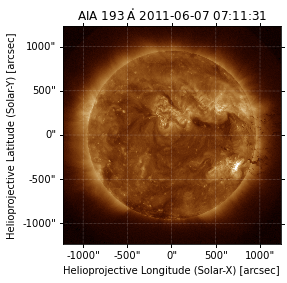

In [73]:
aia, writer = animationData()

In [74]:
fig, ax = plt.subplots(dpi = 150)
plot_obj = aia[len(aia) // 2].plot()

def animate(i):
    ax.set_title("AIA %s %s" % (aia[i].meta['wave_str'],
                                aia[i].meta['t_obs'][:-8]))
    plot_obj.set_data(aia[i].data)
    return (plot_obj,)

anim = an.FuncAnimation(fig, animate, init_func=None,
                    frames=len(aia), interval=150, blit=True)

plt.close(fig)
HTML(anim.to_html5_video())

In [75]:
#Se guarda el video en el directorio VideoActividadSolar en formato mp4
anim.save(fitsDirVideo + newdate + '.mp4', writer=writer, dpi = 300)

In [76]:
#Funcion que halla el tamaño del ROI o región activa en la sucesion de imagenes
def areaImage():
    fitsPaths= sorted(glob(fitsDir+'*193.image_lev1.fits'))
    area = []
    for i in range(1, len(fitsPaths)):
        aiamapFITS_i = sunpy.map.Map(fitsPaths[i])
        aiamapFITS_i1 = sunpy.map.Map(fitsPaths[i])
        label, n, size = contourMap(aiamapFITS_i, aiamapFITS_i1)
        area.append(size)
    return area

In [77]:
area = areaImage()

In [78]:
#Grafica la variacion del area de la region de interes contra el tiempo
def areaImagePlot(FITS_dirPath, data):
    area = pd.DataFrame(data)
    areaImage = []
    Image = []
    
    for i in range(len(area)):
        areaImage.append(area.iat[i,1])
        Image.append(i)

    plt.plot(Image, areaImage,'o', color = 'navy', label = "Área del ROI") 
    plt.xlabel("Imagen")
    plt.ylabel("Valor del Área")
    plt.title("Área en cada Imagen")
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    
    return Image, areaImage

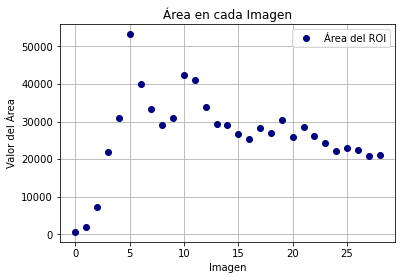

In [79]:
x, y = areaImagePlot(fitsDir, area)

In [80]:
#Modelo matemático que valida la variación en la gráfica mediante una regresion lineal
def comportamientoAreaImage(Image, areaImage):
    x = pd.DataFrame(Image)
    y = pd.DataFrame(areaImage)
    y_pred = []

    lm = LinearRegression()
    lm.fit(x,y)
    b = float(lm.intercept_)
    m = float(lm.coef_)
    print('El valor de la pendiente es:', m)

    for i in range(len(Image)):
        y_pred.append(m*Image[i] + b)

    plt.plot(Image, areaImage,'o', color = 'navy', label = "Área del ROI")
    plt.plot(Image, y_pred, color = 'red', label = "Línea de Tendencia") 
    plt.xlabel("Imagen")
    plt.ylabel("Valor del Área")
    plt.title("Área en cada Imagen")
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

El valor de la pendiente es: 44.64679802955663


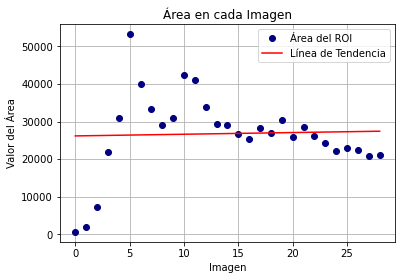

In [81]:
comportamientoAreaImage(x, y)